# [Going Deeper(CV)_4] CutMix 또는 Mixup 비교실험 하기

### * 목차
1. Augmentation을 적용한 데이터셋 만들기         
1) 데이터 불러오기      
2) Random Augmentation    
3) Cutmix Augmentation    
4) Mixup Augmentation    
5) Augmentation 적용    
2. 모델 만들기   
3. 모델 훈련하기   
4. 훈련 과정 시각화하기    
5. Augmentation에 의한 모델 성능 비교      

## 1. Augmentation을 적용한 데이터셋 만들기

### 1) 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

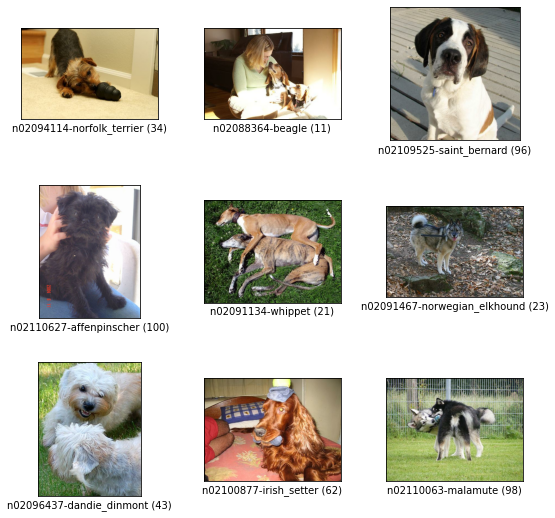

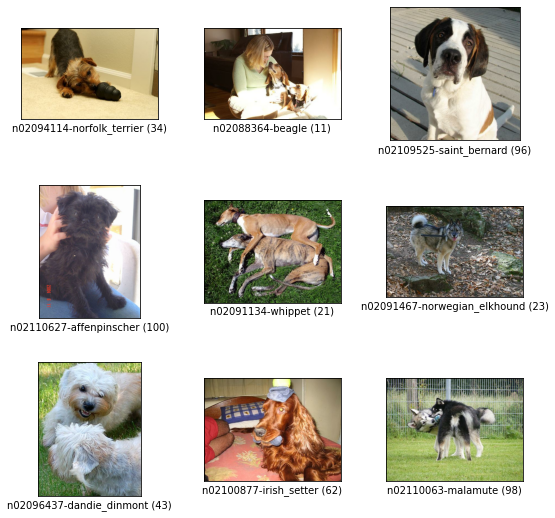

In [4]:
tfds.show_examples(ds_train, ds_info)

### 2) Random Augmentation

In [5]:
# resize
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
# augmentation
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [7]:
def onehot(image,label):
    label = tf.one_hot(label, num_classes)    
    return image,label

In [8]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

### 3) Cutmix Augmentation
(특정 비율로 픽셀별 값을 섞는 방식)

In [10]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

#### 이미지 섞기

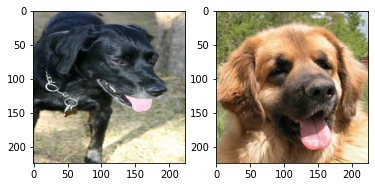

In [11]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [12]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(130, shape=(), dtype=int32)
y :  tf.Tensor(10, shape=(), dtype=int32) tf.Tensor(149, shape=(), dtype=int32)


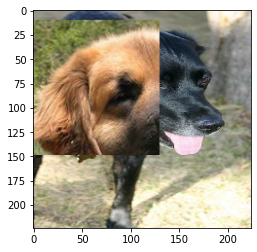

In [13]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### 라벨 섞기

In [14]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.63986766, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [15]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


### 4) Mixup Augmentation
(이미지를 잘라내는 방식)

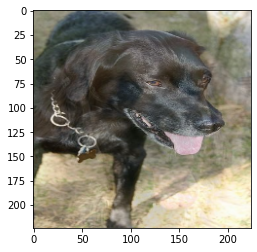

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.76286745 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [16]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [17]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 5) Augmentation 적용

In [18]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    # CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에,
    # 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [19]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train) # 1. original data
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True) # 2. No Augmentation
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True) # 3. with cutmix Augmentation
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True) # 4. with mixup Augmentation
ds_train_cutmix_mixup = apply_normalize_on_dataset(ds_train, with_cutmix=True, with_mixup=True) # 5. with cutmix, mixup Augmentation
ds_test = apply_normalize_on_dataset(ds_test, is_test=True) # 6. test data

## 2. 모델 만들기

In [20]:
# 1. original data
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
# 2. default Augmentation
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
# 3. cutmix Augmentation
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [23]:
# 4. mixup Augmentation
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
# 5. cutmix, mixup Augmentation
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## 3. 모델 훈련하기

cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고
One-Hot 벡터 형태로 변환되었기 때문에 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용

In [25]:
EPOCH = 20

In [26]:
# 1. original data
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 376s 452ms/step - loss: 3.2064 - accuracy: 0.2743 - val_loss: 3.5316 - val_accuracy: 0.1866
Epoch 2/20
750/750 [==============================] - 340s 453ms/step - loss: 0.9486 - accuracy: 0.7362 - val_loss: 1.1819 - val_accuracy: 0.6592
Epoch 3/20
750/750 [==============================] - 340s 454ms/step - loss: 0.3692 - accuracy: 0.9091 - val_loss: 0.9806 - val_accuracy: 0.7154
Epoch 4/20
750/750 [==============================] - 339s 453ms/step - loss: 0.1013 - accuracy: 0.9869 - val_loss: 0.9255 - val_accuracy: 0.7373
Epoch 5/20
750/750 [==============================] - 339s 453ms/step - loss: 0.0340 - accuracy: 0.9975 - val_loss: 0.8908 - val_accuracy: 0.7459
Epoch 6/20
750/750 [==============================] - 339s 452ms/step - loss: 0.0188 - accuracy: 0.9988 - val_loss: 0.9064 - val_accuracy: 0.7471
Epoch 7/20
750/750 [==============================] - 339s 453ms/step - loss: 0.0121 - accuracy: 0.9999 - val_loss: 0.9623 -

In [27]:
# 2. default Augmentation
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 348s 454ms/step - loss: 3.2200 - accuracy: 0.2751 - val_loss: 3.0849 - val_accuracy: 0.2493
Epoch 2/20
750/750 [==============================] - 338s 451ms/step - loss: 1.1028 - accuracy: 0.6823 - val_loss: 1.2304 - val_accuracy: 0.6465
Epoch 3/20
750/750 [==============================] - 339s 453ms/step - loss: 0.5615 - accuracy: 0.8394 - val_loss: 1.1347 - val_accuracy: 0.6784
Epoch 4/20
750/750 [==============================] - 339s 453ms/step - loss: 0.2892 - accuracy: 0.9301 - val_loss: 1.0760 - val_accuracy: 0.6910
Epoch 5/20
750/750 [==============================] - 339s 452ms/step - loss: 0.1565 - accuracy: 0.9708 - val_loss: 1.0336 - val_accuracy: 0.7160
Epoch 6/20
750/750 [==============================] - 339s 453ms/step - loss: 0.0918 - accuracy: 0.9837 - val_loss: 0.9733 - val_accuracy: 0.7255
Epoch 7/20
750/750 [==============================] - 339s 453ms/step - loss: 0.0933 - accuracy: 0.9826 - val_loss: 0.9863 -

In [28]:
# 3. cutmix Augmentation
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 351s 458ms/step - loss: 4.3520 - accuracy: 0.1141 - val_loss: 3.9136 - val_accuracy: 0.1507
Epoch 2/20
750/750 [==============================] - 342s 456ms/step - loss: 3.0414 - accuracy: 0.4038 - val_loss: 1.3597 - val_accuracy: 0.6181
Epoch 3/20
750/750 [==============================] - 342s 456ms/step - loss: 2.6988 - accuracy: 0.5116 - val_loss: 1.1807 - val_accuracy: 0.6585
Epoch 4/20
750/750 [==============================] - 342s 456ms/step - loss: 2.4823 - accuracy: 0.5840 - val_loss: 1.2989 - val_accuracy: 0.6358
Epoch 5/20
750/750 [==============================] - 343s 457ms/step - loss: 2.3226 - accuracy: 0.6312 - val_loss: 1.2651 - val_accuracy: 0.6623
Epoch 6/20
750/750 [==============================] - 343s 457ms/step - loss: 2.1701 - accuracy: 0.6891 - val_loss: 1.1924 - val_accuracy: 0.6770
Epoch 7/20
750/750 [==============================] - 343s 458ms/step - loss: 2.0907 - accuracy: 0.7089 - val_loss: 1.3812 -

In [29]:
# 4. mixup Augmentation
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 350s 457ms/step - loss: 4.2734 - accuracy: 0.1284 - val_loss: 3.8616 - val_accuracy: 0.1369
Epoch 2/20
750/750 [==============================] - 341s 455ms/step - loss: 2.9618 - accuracy: 0.4403 - val_loss: 1.6135 - val_accuracy: 0.5665
Epoch 3/20
750/750 [==============================] - 342s 456ms/step - loss: 2.6488 - accuracy: 0.5554 - val_loss: 1.3273 - val_accuracy: 0.6334
Epoch 4/20
750/750 [==============================] - 342s 457ms/step - loss: 2.4599 - accuracy: 0.6293 - val_loss: 1.3318 - val_accuracy: 0.6259
Epoch 5/20
750/750 [==============================] - 342s 456ms/step - loss: 2.2785 - accuracy: 0.7018 - val_loss: 1.2630 - val_accuracy: 0.6486
Epoch 6/20
750/750 [==============================] - 342s 456ms/step - loss: 2.1766 - accuracy: 0.7385 - val_loss: 1.3019 - val_accuracy: 0.6463
Epoch 7/20
750/750 [==============================] - 342s 456ms/step - loss: 2.0907 - accuracy: 0.7528 - val_loss: 1.2038 -

## 4. 훈련 과정 시각화하기

In [ ]:
import matplotlib.pyplot as plt

#accuracy 시각화
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup['val_accuracy'], 'k')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')

plt.grid(True)
plt.ylim(0.72, 0.76) # 출력하고자 하는  Accuracy 범위를 지정
plt.show()

In [ ]:
#accuracy 시각화
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug['val_loss'], 'r')
plt.plot(history_resnet50_aug['val_loss'], 'b')
plt.plot(history_resnet50_cutmix['val_loss'], 'g')
plt.plot(history_resnet50_mixup['val_loss'], 'k')

plt.title('Model validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')

plt.grid(True)
plt.ylim(0.72, 0.76) # 출력하고자 하는  Accuracy 범위를 지정
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

| Augmentation |val_accuracy|val_loss|
|---|:---:|:---:|
|No Augmentation|0.7453|1.0023|
|With Augmentation|0.7436 |1.0295|
|With CutMix|0.6505 |1.5512|
|With Mixup|0.6621 |1.3514|

#### * 결과1
CutMix, Mixup Augmentation의 결과가 더 좋을 것으로 예상했으나,            
No Augmentation, With Augmentation의 val_accuracy 가 더 높게 나왔음               
실제로도 CutMix가 가장 좋은 성능을 보인다는 논문이 있다. 그 이유는?                     
[CutMix 논문 참고](https://ichi.pro/ko/nonmun-cutmix-jiyeoghwa-ganeunghan-gineung-imiji-bunlyu-eulo-ganglyeoghan-bunlyugileul-hunlyeonhagiwihan-jeong-gyuhw-93629793978512)


#### * 결과2 
Cutout Augmentation은 불필요 픽셀들을 사용하여 비효율적 계산을 한다고 함.           
Mixup Augmentation은 중요한 픽셀들을 위주로 사용하지만, 이미지를 합친 결과가 부자연스러운 문제점이 있다고 함.            

이에 반해 CutMix Augmentation는 이미지를 잘라내고 그부분에 덧붙히는 방법을 사용하여,         
각각의 부분에서 두 클래스를 효율적으로 인식 할 수 있다고 함             
[CutMix 참고 블로그](https://hongl.tistory.com/223)